In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Data provided 

1. Update Date and Time (ISO)
2. Update Duration (ms)
3. Reading Date and Time (ISO)
4. Air pressure (mb)
5. Air temperature (C) – A variable of interest.
6. Tide height (m) – Another variable of interest.
7. Wind direction (deg)
8. Wind gust speed (kn)
9. Wind speed (kn)
10. True air temperature (C) – Ground truth air temperature, against which you should compare your predictions.
11. True tide height (m) – Ground truth tide height, against which you should compare your predictions.
12. Independent tide height prediction (m) – These are some GP predictions prepared earlier for you to compare against, if you so choose.
13. Independent tide height deviation (m) – The standard deviation of the GP predictions above.
14. Dependent tide height prediction (m) – Another GP prediction built using three additional sensors not provided to you.
15. Dependent tide height deviation (m) – The standard deviation of the GP predictions above.
16. Independent air temperature prediction (C) – These are some GP predictions prepared earlier for you to compare against, if you so choose.
17. Independent air temperature deviation (C) – The standard deviation of the GP predictions above.
18. Dependent air temperature prediction (C) – Another GP prediction built using three additional sensors not provided to you.
19. Dependent air temperature deviation (C) – The standard deviation of the GP predictions above.

In [134]:
weather_data = pd.read_csv('sotonmet.txt')
cols = weather_data.columns
date_conversion = lambda date_string: datetime.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S')
weather_data[cols[0]] = weather_data[cols[0]].apply(date_conversion)
weather_data[cols[2]] = weather_data[cols[2]].apply(date_conversion)
all_reading_times = weather_data[cols[2]]
true_tide_heights = weather_data[cols[10]]
true_temperatures = weather_data[cols[11]]
weather_data.dropna(inplace=True)

In [135]:
update_times = weather_data[cols[0]]
update_duration = weather_data[cols[1]]
reading_times = weather_data[cols[2]]
air_pressure = weather_data[cols[3]]
air_temp = weather_data[cols[4]]
tide_heights = weather_data[cols[5]]


In [141]:
def column_plotter(ax, column_indices, color="tab:red"):
    """Plot select columns from Dataframe"""
    for i, col_no in enumerate(column_indices):
        ax[i].scatter(reading_times, weather_data[cols[col_no]], marker="x", s=5, color=color)
        ax[i].set_ylabel(cols[col_no])
    plt.tight_layout()

# Variables for prediction

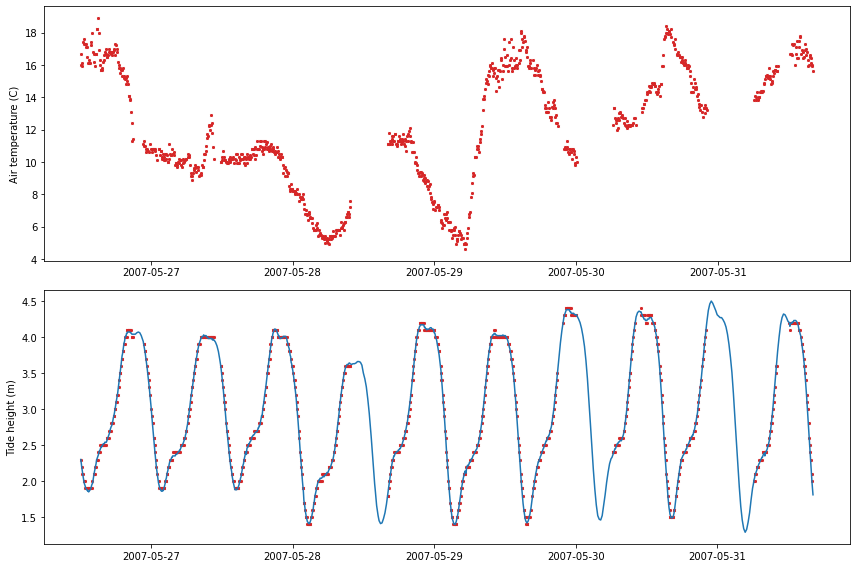

In [142]:
target_cols = [4, 5]
fig, ax = plt.subplots(len(target_cols), 1, figsize=(12,8))
column_plotter(ax, target_cols)
ax[1].plot(all_reading_times, true_tide_heights)

Remarks
- Clear periodic trend in tide (~12.5hr period)
- Amplitude varies fairly smoothly over about a day
- Distinct bumps at high tide and low-mid tide

# Other potentially useful inputs

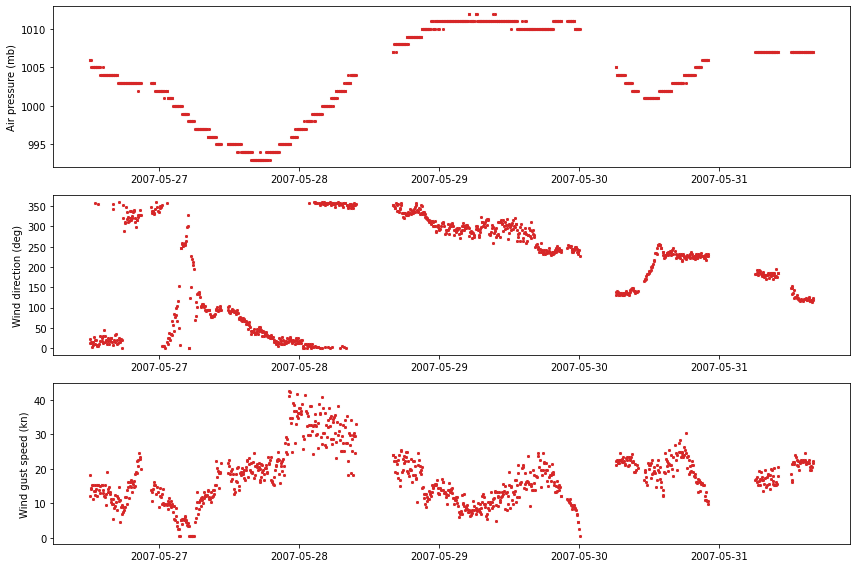

In [143]:
cols_of_interest = [3, 6, 7]
fig, ax = plt.subplots(len(cols_of_interest), 1, figsize=(12,8))
column_plotter(ax,cols_of_interest)

# Comparing wind speed / gust speed 

Conclusion: Not much to be gained by adding both to model

Variance explained by single component : 97.52%


array([[0.77951785, 0.62638001]])

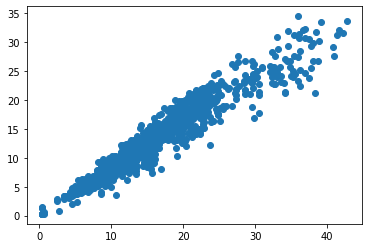

In [8]:
wind_gusts = weather_data[cols[7]].values
wind_speed = weather_data[cols[8]].values
stacked_wind = np.stack((wind_gusts, wind_speed))
plt.scatter(*stacked_wind)
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(stacked_wind.T)
print(f"Variance explained by single component : {round(100*pca.explained_variance_ratio_[0],2)}%")
pca.components_

# Fitting Gaussian Process model

In [29]:
from gps import GaussianProcess
from kernels import IsoSQEKernel, PeriodicKernel, Matern12Kernel, Matern32Kernel
import torch

Pre-processing input data

In [396]:
minute_constant = 60e9  # Scale readings to minutes (sensible length-scale)
start_time = weather_data[cols[2]].values[0]
scaled_reading_times = torch.tensor((weather_data[cols[2]].values - start_time).astype(float)/minute_constant, dtype=torch.float64)
print(type(start_time))

@np.vectorize
def itt(scaled_time_reading):
    """Inverse time transform (ITT)
    Convert scaled time reading to original unix timestamp value."""
    elapsed_ns = np.timedelta64(int(scaled_time_reading*minute_constant), "ns") 
    return start_time + elapsed_ns

raw_tide_heights = torch.tensor(weather_data[cols[5]].values, dtype=torch.float64)
quantisation_variance = 0.02886 # Variance of uniform noise due to quantisation
jitter = quantisation_variance*torch.randn(len(raw_tide_heights))  # Approximate w/ Gaussian
tide_heights = raw_tide_heights + jitter
tide_std, tide_mean = torch.std_mean(tide_heights)
scaled_tide_heights = (tide_heights-tide_mean)
scaled_true_heights = (true_tide_heights-tide_mean.numpy())/tide_std.numpy()  # Scaled ground truth for ref.

@np.vectorize
def iht(scaled_tide_reading):
    """Inverse height transform (IHT)
    Convert scaled tide heigh back to raw value in metres"""
    return scaled_tide_reading * tide_std + tide_mean

<class 'numpy.datetime64'>


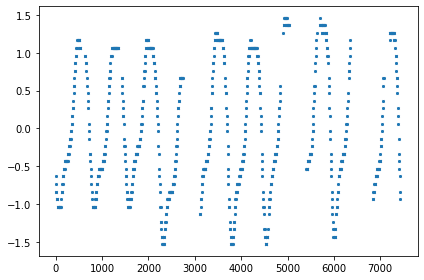

In [85]:
plt.scatter(scaled_reading_times.numpy(), scaled_tide_heights.numpy(), s=5, marker="x")
plt.tight_layout()

Condition number : 132753.95706700283


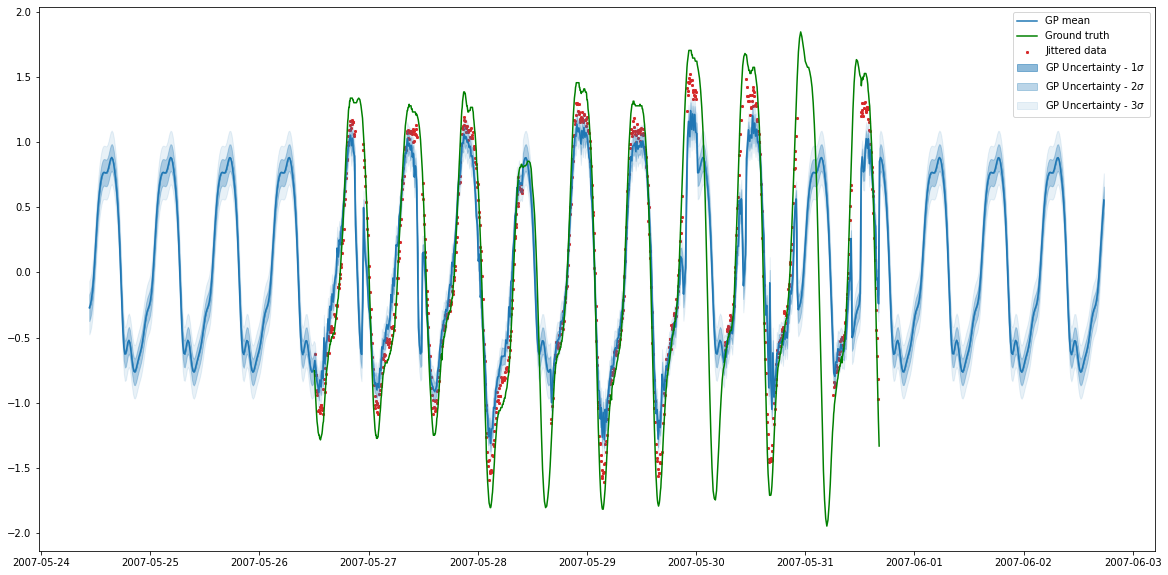

Condition number : 132753.95706700283


tensor(6505.4608, dtype=torch.float64, grad_fn=<MulBackward0>)

In [472]:
l_scale, v_scale = 100, 0.1
period = 60*12 + 60# Exact tidal period about 12h and 25 mins

iso_params = torch.tensor(np.log([l_scale, v_scale]), requires_grad=True)

iso = IsoSQEKernel(iso_params)
matern12 = Matern12Kernel(iso_params)

matern32_params = torch.tensor(np.log([period, 1]), requires_grad=True)
matern32 = Matern32Kernel(matern32_params)

periodic1_params = torch.tensor(np.log([period/1000, 2, period]), requires_grad=True)
periodic1 = PeriodicKernel(periodic1_params)

periodic2_params = torch.tensor(np.log([period/10, 2, period]), requires_grad=True)
periodic2 = PeriodicKernel(periodic2_params)

iso1_params = torch.tensor(np.log([period, 1]), requires_grad=True)
iso2_params = torch.tensor(np.log([5, 0.1]), requires_grad=True)

iso1 = IsoSQEKernel(iso1_params)
iso2 = IsoSQEKernel(iso2_params)

combined_kernel = periodic1 + iso2

gp1 = GaussianProcess(covar_kernel=combined_kernel, sigma_n=.1, training_data=scaled_reading_times, 
                      labels=scaled_tide_heights, learn_noise=True)

test_times = torch.linspace(-0.4*torch.max(scaled_reading_times), 1.4*torch.max(scaled_reading_times), 1000)
test_means, test_vars = gp1.compute_predictive_means_vars(test_times)
sigma_vector = np.diag(test_vars)**0.5

plt.figure(figsize=(20,10))
plt.scatter(itt(scaled_reading_times), scaled_tide_heights, s=5, marker="x", label="Jittered data", color="tab:red")
plt.plot(itt(test_times), test_means, color="tab:blue", label="GP mean")

alphas = [0.5, 0.3, 0.1]
for i in range(3):
    plt.fill_between(itt(test_times), test_means-i*sigma_vector, test_means+i*sigma_vector,
                    alpha=alphas[i], color="tab:blue", label=fr"GP Uncertainty - ${i+1}\sigma$")
    
plt.plot(all_reading_times, scaled_true_heights, label="Ground truth", color="green")
plt.legend()
plt.show()

gp1.compute_nll(True)

In [442]:
gp1.optimise_hyperparams(100, lr=1e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Old hyper-parameters: tensor([360.0000,   1.0000], dtype=torch.float64, grad_fn=<ExpBackward>)tensor([ 72.0000,   1.5000, 720.0000], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([ 72.0000,   2.0000, 720.0000], dtype=torch.float64,
       grad_fn=<ExpBackward>)
Old noise std : 0.10000000000000002
Negative log-likelihood : 1165.4201061324375


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]

New hyper-parameters: tensor([224.5345,   0.6603], dtype=torch.float64, grad_fn=<ExpBackward>)tensor([ 17.6331,   0.9904, 310.5141], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([ 17.9063,   6.6034, 744.8753], dtype=torch.float64,
       grad_fn=<ExpBackward>)
New noise std : 0.04486065815142761
Negative log-likelihood : 784.5090746018841


Condition number : 19822613.286337975


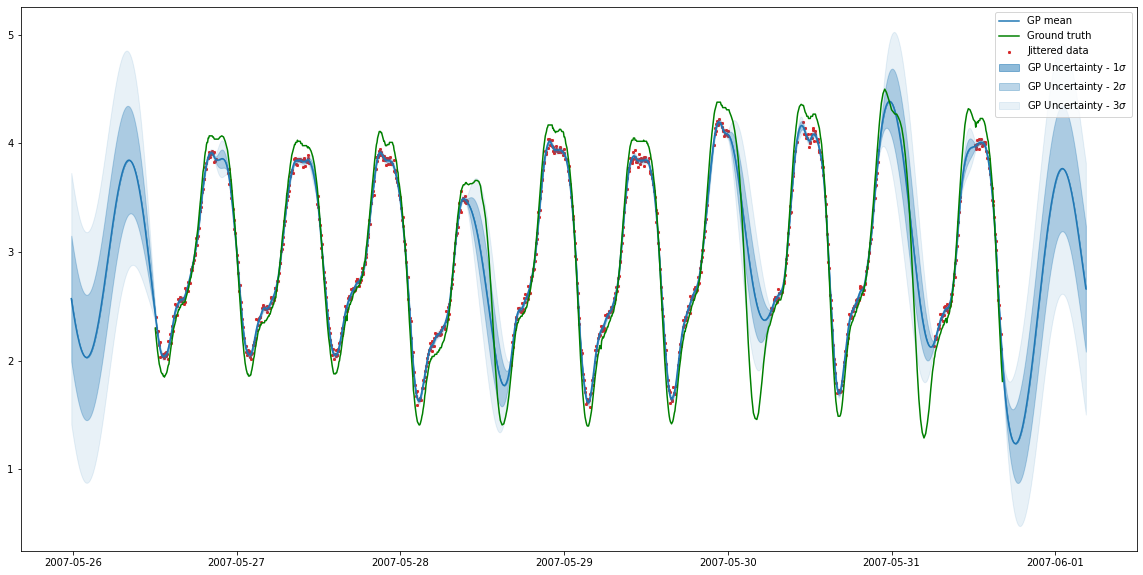

In [443]:
test_times = torch.linspace(-0.1*torch.max(scaled_reading_times), 1.1*torch.max(scaled_reading_times), 1000)
test_means, test_vars = gp1.compute_predictive_means_vars(test_times)
sigma_vector = np.diag(test_vars)**0.5

plt.figure(figsize=(20,10))
plt.scatter(itt(scaled_reading_times), iht(scaled_tide_heights), s=5, marker="x", label="Jittered data", color="tab:red")
plt.plot(itt(test_times), iht(test_means), color="tab:blue", label="GP mean")

alphas = [0.5, 0.3, 0.1]
for i in range(3):
    plt.fill_between(itt(test_times), iht(test_means-i*sigma_vector), iht(test_means+i*sigma_vector),
                    alpha=alphas[i], color="tab:blue", label=fr"GP Uncertainty - ${i+1}\sigma$")

plt.plot(all_reading_times, true_tide_heights, label="Ground truth", color="green")
plt.legend()
plt.show()

Optimising hyper-parameters (gradient descent of the marginal likelihood)

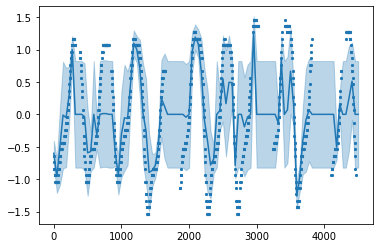

In [329]:
new_test_means, new_test_vars = gp1.compute_predictive_means_vars(test_times)

plt.figure()
plt.scatter(scaled_reading_times.numpy(), scaled_tide_heights.numpy(), s=5, marker="x")
plt.plot(test_times, new_test_means, color="tab:blue")
plt.fill_between(test_times, new_test_means-np.diag(new_test_vars)**0.5, new_test_means+np.diag(new_test_vars)**0.5,
                 alpha=0.3, color="tab:blue")
plt.show()

In [62]:
l_scale, v_scale = 50.0, 2.0
iso_params = torch.tensor([l_scale, v_scale], requires_grad=True)
periodic_params = torch.tensor([l_scale, v_scale, 3], requires_grad=True)
iso_test = IsoSQEKernel([iso_params])
periodic = PeriodicKernel([periodic_params])
a = torch.tensor([[1.0, 2], [1,2], [1, 2]])
b = torch.tensor([[1,2], [3,4]])
c, d = torch.tensor([1.0]), torch.tensor(2.0)

periodic(a,b)

tensor([[4.0000, 3.9972],
        [4.0000, 3.9972],
        [4.0000, 3.9972]], grad_fn=<MulBackward0>)

In [248]:
def f(x, x_):
    return np.linalg.norm(x-x_)

def compute_covariance(X, Y):
    def covariance_column(x_i):
        return np.apply_along_axis(f, 1, Y, x_i)
    return np.apply_along_axis(covariance_column, 1, X)

In [85]:
X = np.array([1, 1, 1, 1])
Y = np.array([2, 2])
compute_covariance(X, Y)

AxisError: axis 1 is out of bounds for array of dimension 1